# AEP/SWEPCO Texas Electric Vehicle EV R&D Study
## Date: 11/1/2023
## Author: Russell Hedrick

### Description: Residential field study comparing the performance between Lvl 1 and Lvl 2 Plug-In chargers. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os

In [2]:
# Change directory to Raw Data folder and create list of each data file
current_path = os.getcwd()
path_list = current_path.split("\\")
data_path = "\\".join(path_list[:-1]) + "\\Raw"
data_files = os.listdir(data_path)

In [3]:
# Create function to prep DataFrames for analysis - expecting preformatted .csv file
def data_prep(file_name, file_path=""):
    if file_path != "":
        df = pd.read_csv(file_path+"\\"+file_name)
    else:
        df = pd.read_csv(file_name)

    # 1) Convert timestamps to datetime object
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    # 2) Drop unecessary columns
    df = df.drop(df.columns[1:3], axis=1)
    # 3) Add date column for future grouping
    df.insert(loc=1, column="Date", value=df["Date & Time"].dt.to_period('D'))
    # 4) Add month column for future grouping
    df.insert(loc=2, column="Month", value=df["Date & Time"].dt.to_period('M'))
    # 5) Add dt column
    df.insert(loc=3, column="dt", value=df["Date & Time"].diff())
    df["dt"] = df["dt"].dt.total_seconds()/60 # convert from seconds to minutes
    # 6) Add column for L1 Energy
    df["Lvl1 Energy [kWh]"] = df["Level 1 Power+ [kW]"]*df["dt"]/60
    # 7) Add column for L2 Energy
    df["Lvl2 Energy [kWh]"] = df["Level 2 Power+ [kW]"]*df["dt"]/60
    # 8) Add column for Temp in Fahrenheit
    df["Temp [F]"] = df["Ambient [°C]"]*1.8+32
    
    return df


In [103]:
def event_counter(data, threshold, window, gap=0):
    """
    Custom window-style event counter algorithm to be used with time series data.
    data: 1D time series data that event counting is to occur on
    threshold: the intercept at which event counting is triggered
    window: the number of consecutive events that must occur before an event is detected
    gap: An optional parameter representing the gap between events. 
    If the gap between events is greater than this value, the algorithm considers it as a new event.
    """
    events = 0
    window_counter = 0
    gap_counter = 0
    event_start_list = []
    event_end_list = []

    for count, item in enumerate(data): 
        if item > threshold:
            if window_counter == window:
                events += 1
                event_start_list.append(count - window)
            window_counter += 1
        elif window_counter > window:
            if gap_counter < gap:
                gap_counter += 1
            else:
                gap_counter = 0
                event_end_list.append(count - gap)
                window_counter = 0
            
    try:        
        event_durations = np.array(event_end_list) - np.array(event_start_list)
    except ValueError:
        event_start_list.pop(-1)
        event_durations = np.array(event_end_list) - np.array(event_start_list)
    
    return events, event_start_list, event_durations

In [18]:
# Read in single file into pandas 
df = data_prep(data_files[-1], data_path)

In [5]:
# Combine all files into dictionary of Dataframes
pt_start = time.time()
df = {}
for i in range(1,17):
    try:
        df[i] =  data_prep(f"site{i}_minute.csv", data_path)
    except Exception as e:
        print(e)
pt = time.time() - pt_start
print(f"Process Time: {pt}")

Process Time: 40.491703033447266


In [5]:
df[12].head()

,Date & Time,Date,Month,dt,L1 Voltage [V],L2 Voltage [V],L1-L2 Voltage [V],L1 Level 2 Amperage [A],L2 Level 2 Amperage [A],L2 Level 1 Amperage [A],Level 2 Power [kW],Level 2 Power+ [kW],Level 1 Power [kW],Level 1 Power+ [kW],Ambient [°C],Lvl1 Energy [kWh],Lvl2 Energy [kWh],Temp [F]
0,2022-09-10 11:00:00,2022-09-10,2022-09,NaN,117.565399,117.479722,234.924375,20.699939,20.380347,0.080192,4.775990,4.775990,0.000121,0.000214,27.883201,NaN,NaN,82.189762
1,2022-09-10 11:15:00,2022-09-10,2022-09,15.0,118.416276,118.278698,236.573455,0.162897,0.137921,0.080781,0.004811,0.004811,0.000424,0.000424,28.101632,0.000106,0.001203,82.582937
2,2022-09-10 11:30:00,2022-09-10,2022-09,15.0,118.132179,118.093021,236.103871,0.162530,0.137786,0.080862,0.004802,0.004802,0.000426,0.000427,28.395742,0.000107,0.001201,83.112336
3,2022-09-10 11:45:00,2022-09-10,2022-09,15.0,117.983759,117.626918,235.489809,0.159708,0.135776,0.079010,0.004773,0.004773,0.000419,0.000420,28.665935,0.000105,0.001193,83.598684
4,2022-09-10 12:00:00,2022-09-10,2022-09,15.0,118.483446,118.428958,236.790799,0.152941,0.131580,0.075801,0.004766,0.004766,0.000440,0.000443,28.911908,0.000111,0.001191,84.041434


In [6]:
for item in df:
    print(f"Site {item}: {df[item].shape}")

Site 1: (197970, 18)
Site 2: (520508, 18)
Site 3: (475716, 18)
Site 4: (531503, 18)
Site 5: (529347, 18)
Site 6: (332042, 18)
Site 7: (492052, 18)
Site 8: (510202, 18)
Site 9: (529233, 18)
Site 10: (466285, 18)
Site 11: (496832, 18)
Site 12: (489154, 18)
Site 13: (456351, 18)
Site 14: (446511, 18)
Site 15: (344331, 18)
Site 16: (336860, 18)


# EDA and Plotting

In [42]:
# Site 1: A. Alston
# Site 2: P. Almanza
# Site 3: A. Yapha
# Site 4: Z. Hernandez
# Site 5: J. McCart
# Site 6: R. Konopczyk
# Site 7: M. Sikes
# Site 8: J. Webb
# Site 9: C. Smith
# Site 10: J. Ludwig
# Site 11: M. Reyes
# Site 12: A. Bunton
# Site 13: B. McDermott
# Site 14: J. Moore
# Site 15: K. Davis
# Site 16: K. Squires

### Level 1 Daily Profiles

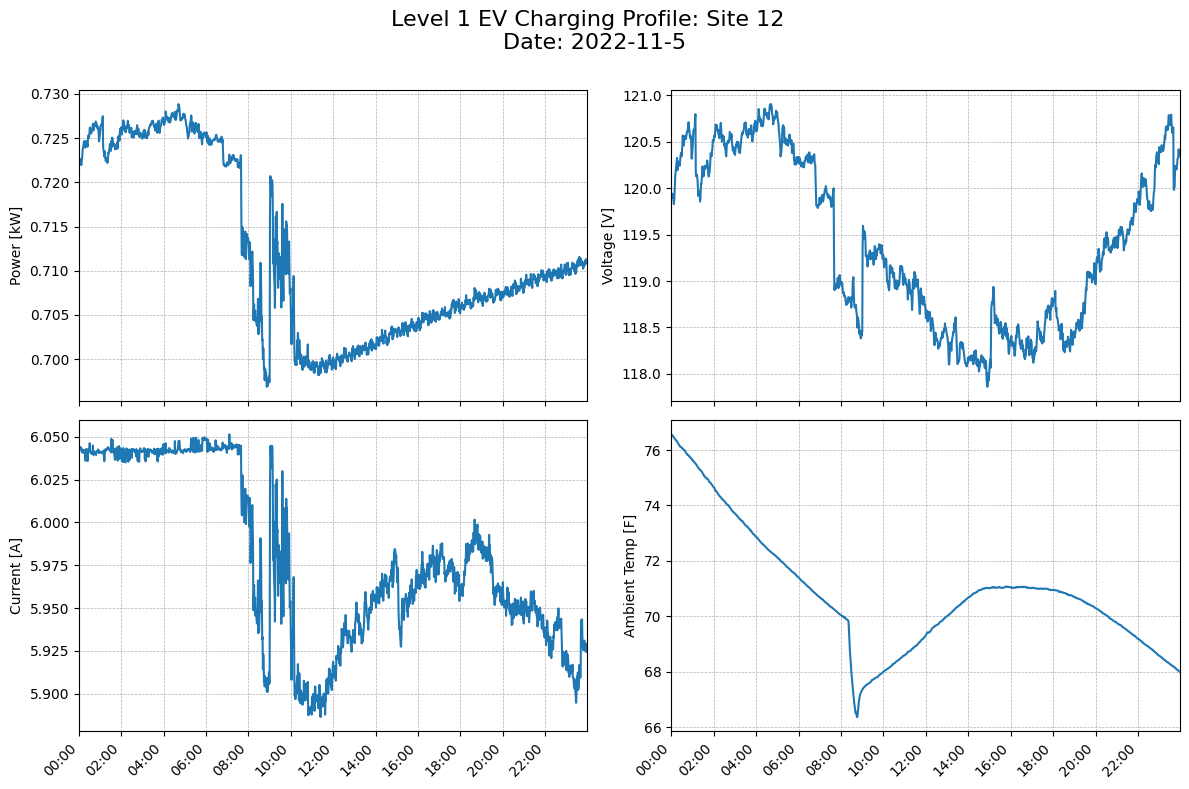

In [8]:
plot_date = "2022-11-5"
site = 12
filter_df = df[site][df[site].Date == plot_date]
x = filter_df[df[site].columns[0]] # Time
# Dependent Variables
y1 = filter_df["Level 1 Power+ [kW]"]
y2 = filter_df["L2 Voltage [V]"]
y3 = filter_df["L2 Level 1 Amperage [A]"]
y4_column = -1 # Ambient Temp
y4 = filter_df[df[site].columns[y4_column]]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3)
ax4.plot(x, y4)

# Format the x-axis timestamps
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Display hours and minutes
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set the interval for x-axis labels (e.g., every hour)
ax1.set_xlim(x.min().replace(minute=0, second=0), x.max())

for ax in (ax1, ax2, ax3, ax4):
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.5)

# Rotate x-axis labels for better readability
for ax in (ax1, ax2, ax3, ax4):
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
# Set labels and titles
ax1.set_ylabel("Power [kW]")
ax2.set_ylabel("Voltage [V]")
ax3.set_ylabel("Current [A]")
ax4.set_ylabel("Ambient Temp [F]")     

fig.suptitle(f"Level 1 EV Charging Profile: Site {site}  \nDate: {plot_date}", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88) 
plt.show()

### Notes

In [ ]:
# Site 15(Kyle Davis): 
# - Random shutoffs occuring between 4/3/23 - 4/5/23
# Site 12 (A. Bunton):
# - multi day lvl 1 charge 11/5/2022
# Site 4 (Z. Hernandez):
# - Various current and power draw levels (represented well in histogram)

### Level 2 Daily Profiles

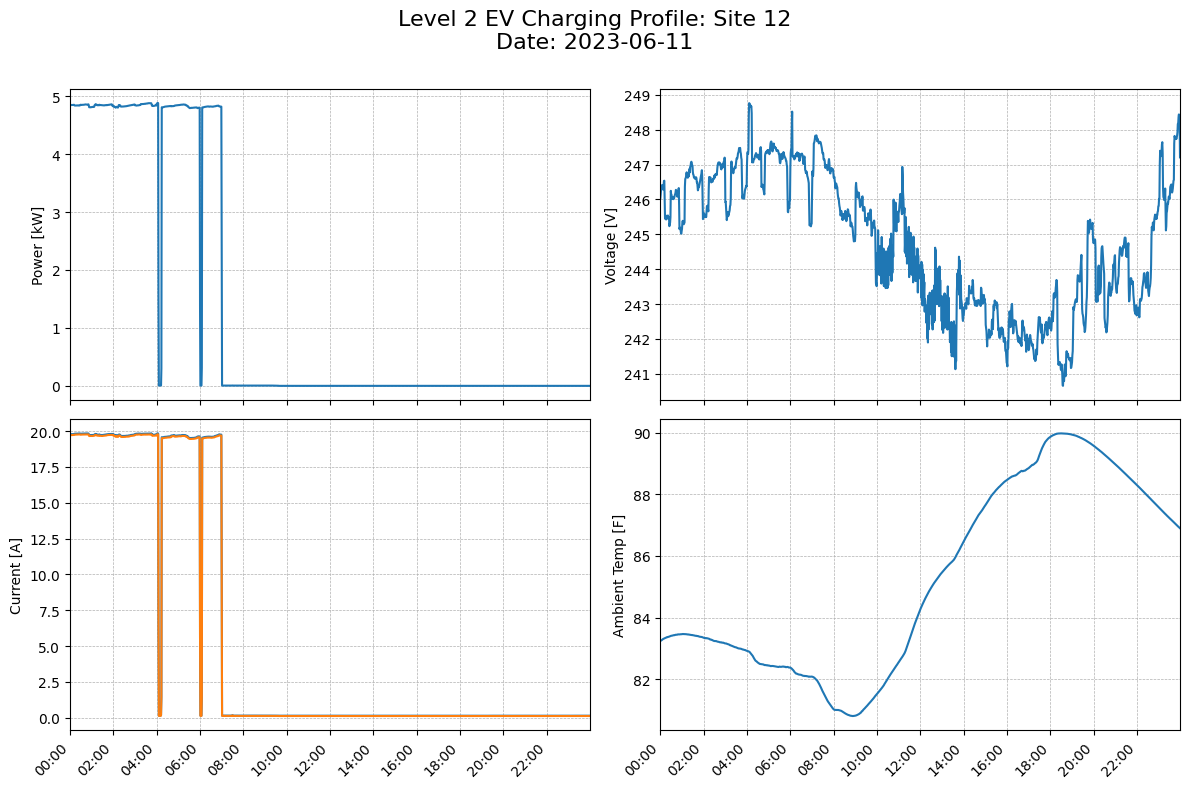

In [164]:
plot_date = "2023-06-11"
site = 12
filter_df = df[site][df[site].Date == plot_date]
x = filter_df[df[site].columns[0]] # Time
# Dependent Variables
y1 = filter_df["Level 2 Power+ [kW]"]
y2 = filter_df["L1-L2 Voltage [V]"]
y3a = filter_df["L1 Level 2 Amperage [A]"]
y3b = filter_df["L2 Level 2 Amperage [A]"]
y4_column = -1 # Ambient Temp
y4 = filter_df[df[site].columns[y4_column]]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))

ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3a)
ax3.plot(x, y3b)
ax4.plot(x, y4)

# Format the x-axis timestamps
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Display hours and minutes
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set the interval for x-axis labels (e.g., every hour)
ax1.set_xlim(x.min().replace(minute=0, second=0), x.max())

for ax in (ax1, ax2, ax3, ax4):
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle='--', linewidth=0.5)

# Rotate x-axis labels for better readability
for ax in (ax1, ax2, ax3, ax4):
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
# Set labels and titles
ax1.set_ylabel("Power [kW]")
ax2.set_ylabel("Voltage [V]")
ax3.set_ylabel("Current [A]")
ax4.set_ylabel("Ambient Temp [F]")     

fig.suptitle(f"Level 2 EV Charging Profile: Site {site}\nDate: {plot_date}", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88) 
plt.show()

### Histograms

#### Level 2 Charging Frequencies

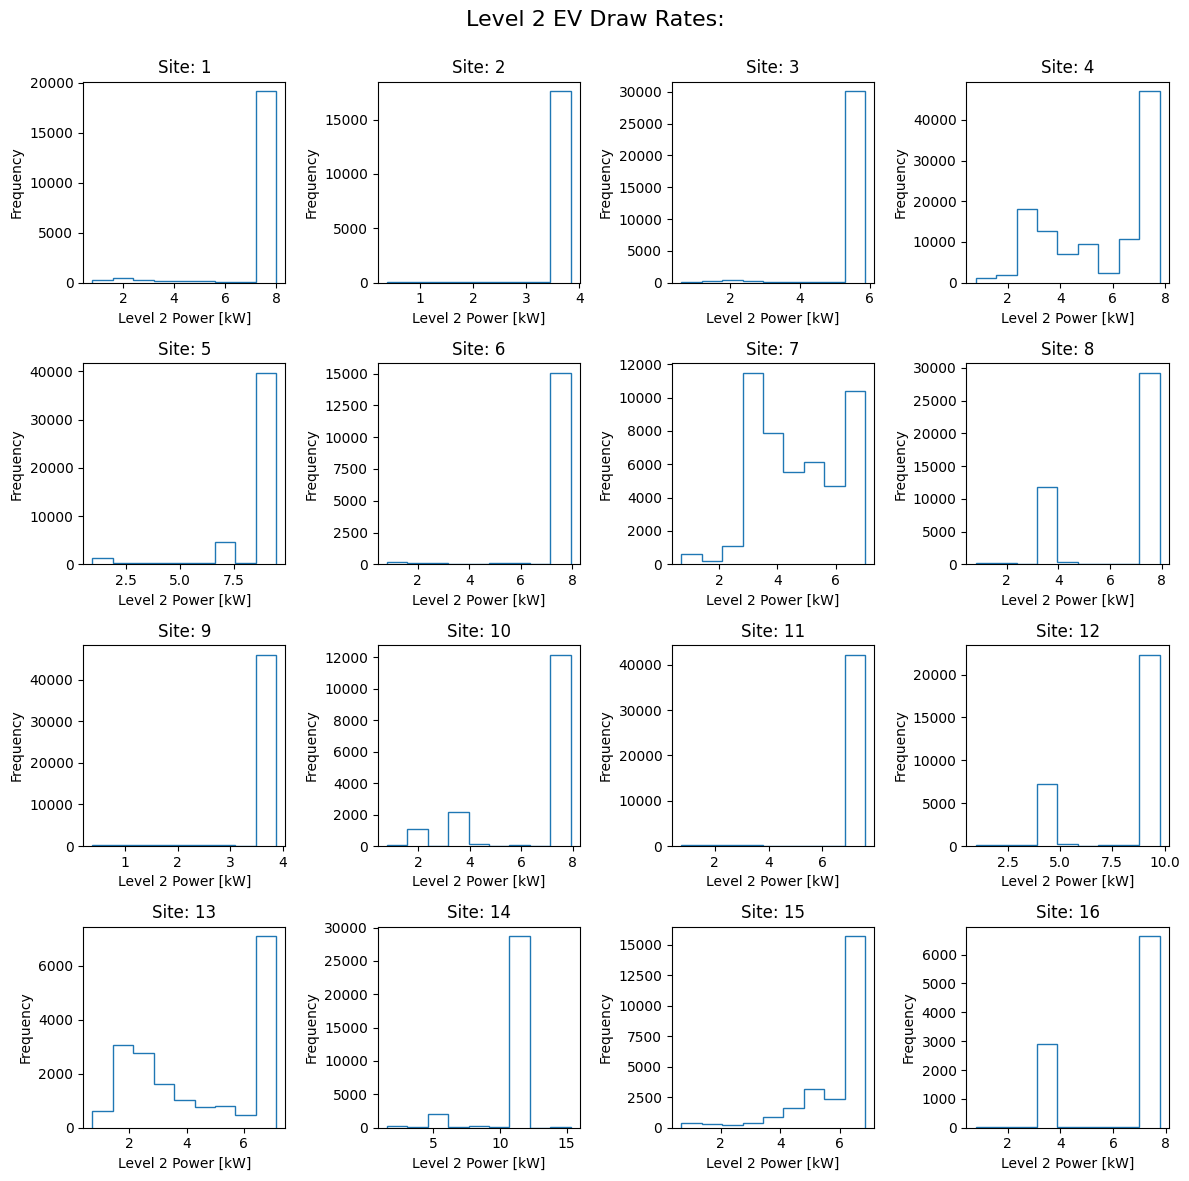

In [14]:
feature_name = "Level 2 Power [kW]"

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Iterate through the dictionary and create histograms
for n in range(1, 17):
    ax = axes[n-1]  # Select the current subplot
    df_n = df[n]  # Get the DataFrame for this subplot
    feature_data = df_n[feature_name]  # Extract the feature data
    counts, bins = np.histogram(feature_data)
    
    # Plot a histogram
    ax.stairs(counts[1:], bins[1:])
   
    ax.set_title(f'Site: {n}')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Frequency')

fig.suptitle(f"Level 2 EV Draw Rates:\n", fontsize=16)
# Adjust layout
plt.tight_layout()
#plt.savefig('histogram.png')
plt.show()

#### Combined Level 1 & 2 Charging Frequencies

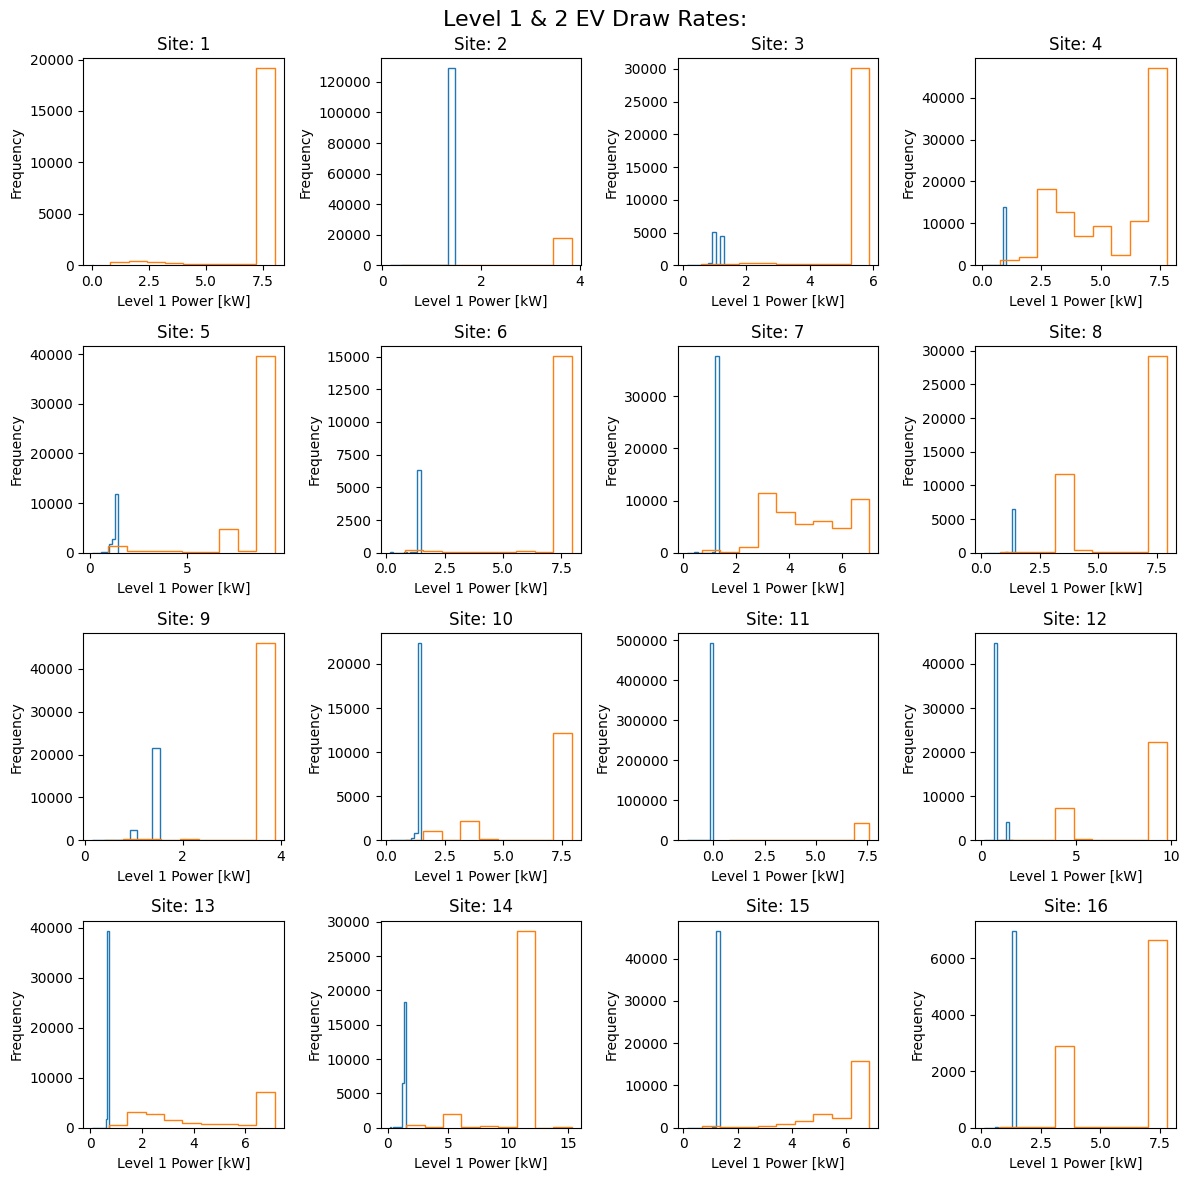

In [15]:
feature_name1 = "Level 1 Power [kW]"
feature_name2 = "Level 2 Power [kW]"

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Iterate through the dictionary and create histograms
for n in range(1, 17):
    ax = axes[n-1]  # Select the current subplot
    df_n = df[n]  # Get the DataFrame for this subplot
    feature_data1 = df_n[feature_name1]  # Extract the feature data
    feature_data2 = df_n[feature_name2]  # Extract the feature data
    counts1, bins1 = np.histogram(feature_data1)
    counts2, bins2 = np.histogram(feature_data2)
    
    # Plot a histogram
    ax.stairs(counts1[1:], bins1[1:])
    ax.stairs(counts2[1:], bins2[1:])
    
    ax.set_title(f'Site: {n}')
    ax.set_xlabel("Draw Rate [kW]")
    ax.set_ylabel('Frequency')

fig.suptitle(f"Level 1 & 2 EV Draw Rates:", fontsize=16)
# Adjust layout
plt.tight_layout()
#plt.savefig('histogram.png')
plt.show()

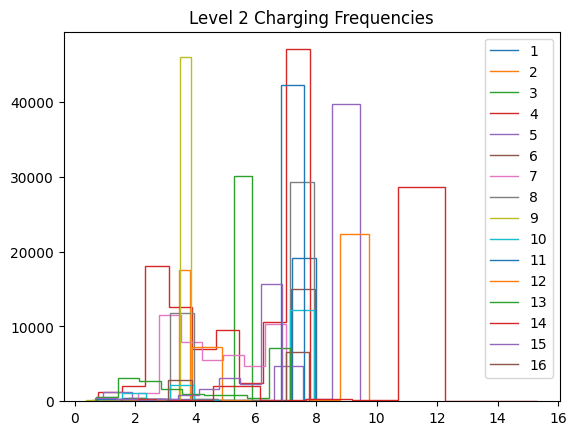

In [15]:
for site in df:
    x = df[site]["Level 2 Power+ [kW]"]
    counts, bins = np.histogram(x)
    plt.stairs(counts[1:], bins[1:], label=f"{site}")
plt.title("Level 2 Charging Frequencies")
plt.legend()
plt.show()

### Demand Curves

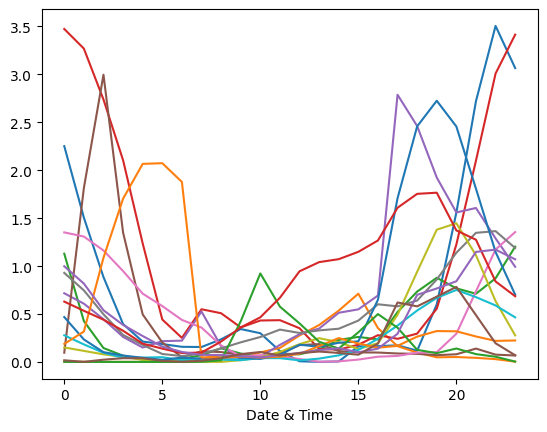

In [136]:
for site in df:
    monthly_demand = df[site].groupby([df[site]["Date & Time"].dt.hour])["Level 2 Power+ [kW]"].mean()
    monthly_demand.plot()

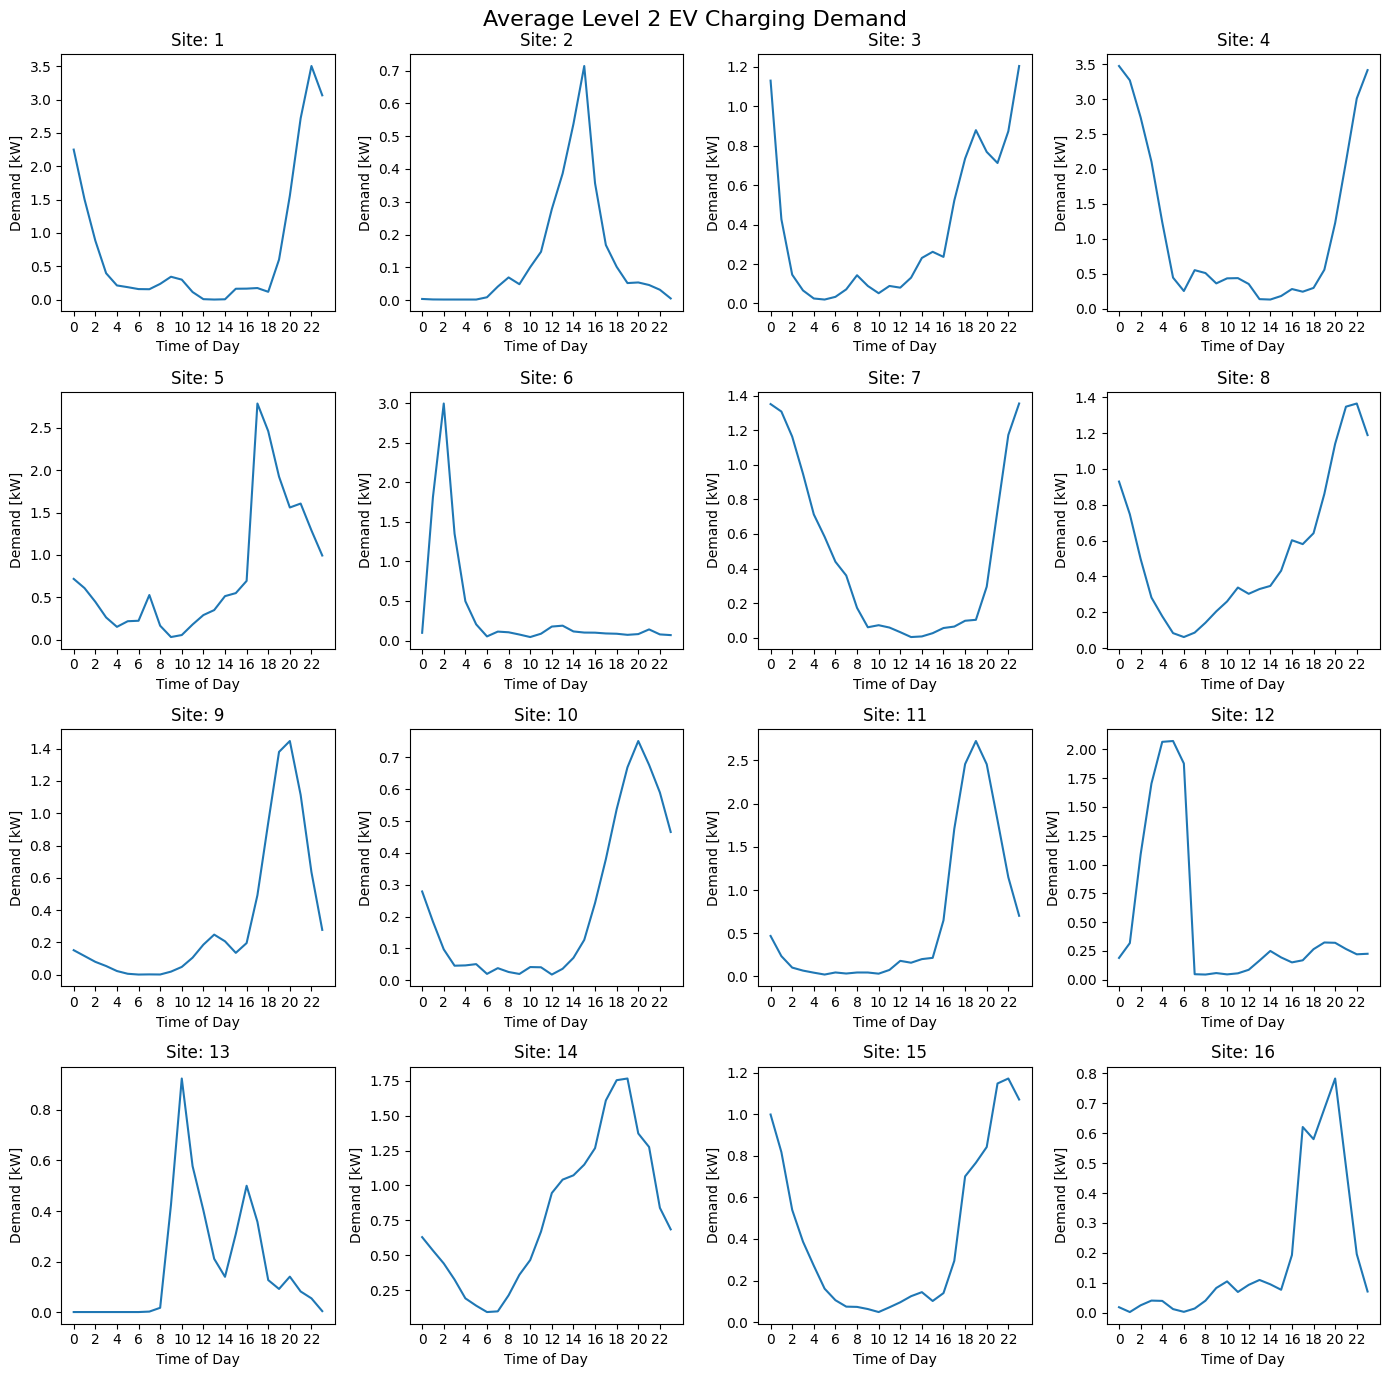

In [152]:
feature_name = "Level 2 Power [kW]"

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

# Flatten the axes array for easier indexing
axes = axes.ravel()
# Iterate through the dictionary and create plots
for n in range(1, 17):
    ax = axes[n-1]  # Select the current subplot
    hour_df = df[n].groupby([df[n]["Date & Time"].dt.hour])[feature_name].mean() # Get the hourly grouped data for feature 1

    ax.plot(hour_df)

    ax.set_title(f'Site: {n}')
    ax.set_xlabel("Time of Day")
    ax.set_ylabel('Demand [kW]')

    # Set ticks for each hour
    ax.set_xticks([hour for hour in range(0, 23, 2)])
    
fig.suptitle(f"Average Level 2 EV Charging Demand", fontsize=16)
plt.tight_layout()
plt.savefig('Lvl2-Charge_Demand-Curves.png')
plt.show()

In [20]:
print(df[14]["L2 Level 2 Amperage [A]"][(df[14]["L2 Level 2 Amperage [A]"]>1) & (df[14]["L2 Level 2 Amperage [A]"]<48)].mean())
print(df[14].loc[df[14]["L2 Level 2 Amperage [A]"] > 45, "L2 Level 2 Amperage [A]"].mean())

30.425574916097432
48.19973149461206


### Summary Results

In [16]:
results = {}
for site in df:
    days = len(df[site].Date.unique())
    l1_mean_power = round(df[site].loc[df[site]["Level 1 Power+ [kW]"] > 0.1, "Level 1 Power+ [kW]"].mean(),2)
    l2_mean_power = round(df[site].loc[df[site]["Level 2 Power+ [kW]"] > 0.5, "Level 2 Power+ [kW]"].mean(),2)
    l1_mean_current = round(df[site].loc[df[site]["L2 Level 1 Amperage [A]"] > 0.1, "L2 Level 1 Amperage [A]"].mean(),2)
    l2_mean_current = round(max(df[site].loc[df[site]["L1 Level 2 Amperage [A]"] > 1, "L1 Level 2 Amperage [A]"].mean(),df[site].loc[df[site]["L2 Level 2 Amperage [A]"] > 1, "L2 Level 2 Amperage [A]"].mean()),2)
    l1_mean_voltage = round(df[site].loc[df[site]["L2 Level 1 Amperage [A]"] > 0.1, "L2 Voltage [V]"].mean(),2)
    l2_mean_voltage = round(df[site].loc[df[site]["L1 Level 2 Amperage [A]"] > 0.1, "L1-L2 Voltage [V]"].mean(),2)
    l1_events, _, l1_event_duration = event_counter(df[site]["Level 1 Power+ [kW]"], 0.2, 15)
    l2_events, _, l2_event_duration = event_counter(df[site]["Level 2 Power+ [kW]"], 1.5, 15)
    annual_energy = round((df[site]["Lvl1 Energy [kWh]"].sum() + df[site]["Lvl2 Energy [kWh]"].sum())/(days/365),2)
    annual_cost = round(annual_energy*0.15,2)

    results[f"Site {site}"] = {"Days": days,
                     "Lvl1 Mean Power [kW]": l1_mean_power,
                     "Lvl2 Mean Power [kW]": l2_mean_power,
                     "Lvl1 Mean Current [A]": l1_mean_current,
                     "Lvl2 Mean Current [A]": l2_mean_current,
                     "Lvl1 Mean Voltage [V]": l1_mean_voltage,
                     "Lvl2 Mean Voltage [V]": l2_mean_voltage,
                     "Lvl1 Events": l1_events,
                     "Lvl2 Events": l2_events,
                     "Avg Lvl1 Charge Time [min]": round(np.mean(l1_event_duration),1), 
                     "Avg Lvl2 Charge Time [min]": round(np.mean(l2_event_duration),1),         
                     "Annual Energy [kWh]": annual_energy,
                     "Annual Cost [$]": annual_cost}
    
    print(f"""
    Site {site}: 
    Days = {days}
    Lvl 1 Power = {l1_mean_power} kW"
    Lvl 2 Power = {l2_mean_power} kW"
    Lvl 1 Current = {l1_mean_current} A
    Lvl 2 Current = {l2_mean_current} A
    Lvl 1 Voltage = {l1_mean_voltage} V
    Lvl 2 Voltage = {l2_mean_voltage} V
    Lvl 1 Charge Events = {l1_events}
    Lvl 2 Charge Events = {l2_events}
    Avg Lvl1 Charge Time = {round(np.mean(l1_event_duration),1)} min
    Avg Lvl2 Charge Time = {round(np.mean(l2_event_duration),1)} min
    Annual Energy = {annual_energy} kWh
    Electricity Cost = ${annual_cost}
    """)
    

C:\Users\rhedrick\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rhedrick\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



    Site 1: 
    Days = 138
    Lvl 1 Power = nan kW"
    Lvl 2 Power = 7.46 kW"
    Lvl 1 Current = 0.1 A
    Lvl 2 Current = 30.17 A
    Lvl 1 Voltage = 124.94 V
    Lvl 2 Voltage = 249.56 V
    Lvl 1 Charge Events = 0
    Lvl 2 Charge Events = 134
    Avg Lvl1 Charge Time = nan min
    Avg Lvl2 Charge Time = 153.0 min
    Annual Energy = 6847.92 kWh
    Electricity Cost = $1027.19
    

    Site 2: 
    Days = 424
    Lvl 1 Power = 1.41 kW"
    Lvl 2 Power = 3.75 kW"
    Lvl 1 Current = 3.04 A
    Lvl 2 Current = 15.48 A
    Lvl 1 Voltage = 122.13 V
    Lvl 2 Voltage = 244.36 V
    Lvl 1 Charge Events = 331
    Lvl 2 Charge Events = 194
    Avg Lvl1 Charge Time = 391.2 min
    Avg Lvl2 Charge Time = 89.7 min
    Annual Energy = 4191.29 kWh
    Electricity Cost = $628.69
    

    Site 3: 
    Days = 392
    Lvl 1 Power = 1.1 kW"
    Lvl 2 Power = 5.56 kW"
    Lvl 1 Current = 8.73 A
    Lvl 2 Current = 23.3 A
    Lvl 1 Voltage = 120.69 V
    Lvl 2 Voltage = 244.76 V
    Lvl 1 Charge

In [17]:
# Convert results dictionary to pandas DataFrame and export to excel file
results_df = pd.DataFrame(results).transpose() 
results_df.to_excel("ev_results.xlsx")

In [18]:
results_df.head()

,Days,Lvl1 Mean Power [kW],Lvl2 Mean Power [kW],Lvl1 Mean Current [A],Lvl2 Mean Current [A],Lvl1 Mean Voltage [V],Lvl2 Mean Voltage [V],Lvl1 Events,Lvl2 Events,Avg Lvl1 Charge Time [min],Avg Lvl2 Charge Time [min],Annual Energy [kWh],Annual Cost [$]
Site 1,138.0,NaN,7.46,0.10,30.17,124.94,249.56,0.0,134.0,NaN,153.0,6847.92,1027.19
Site 2,424.0,1.41,3.75,3.04,15.48,122.13,244.36,331.0,194.0,391.2,89.7,4191.29,628.69
Site 3,392.0,1.10,5.56,8.73,23.30,120.69,244.76,21.0,327.0,466.1,90.7,3640.53,546.08
Site 4,414.0,0.97,5.54,7.97,22.71,123.87,249.22,38.0,415.0,367.2,260.7,10407.83,1561.17
Site 5,391.0,1.30,8.33,11.07,36.10,117.30,241.85,50.0,491.0,328.0,91.3,6999.43,1049.91


## TESTING

In [112]:
pts = time.time()
for site in df:
    print(f"""
    Site {site}:
    Level 1 Charge Events = {event_counter(df[site]["Level 1 Power [kW]"], 0.1, 15, 15)[0]}
    Level 2 Charge Events = {event_counter(df[site]["Level 2 Power [kW]"], 1, 15, 15)[0]}""")
pt = time.time() - pts
print(pt)


    Site 1:
    Level 1 Charge Events = 0
    Level 2 Charge Events = 1297

    Site 2:
    Level 1 Charge Events = 8100
    Level 2 Charge Events = 1122

    Site 3:
    Level 1 Charge Events = 616
    Level 2 Charge Events = 1971

    Site 4:
    Level 1 Charge Events = 876
    Level 2 Charge Events = 6908

    Site 5:
    Level 1 Charge Events = 1033
    Level 2 Charge Events = 2945

    Site 6:
    Level 1 Charge Events = 405
    Level 2 Charge Events = 981

    Site 7:
    Level 1 Charge Events = 2380
    Level 2 Charge Events = 2986

    Site 8:
    Level 1 Charge Events = 407
    Level 2 Charge Events = 2622

    Site 9:
    Level 1 Charge Events = 1507
    Level 2 Charge Events = 2940

    Site 10:
    Level 1 Charge Events = 1469
    Level 2 Charge Events = 977

    Site 11:
    Level 1 Charge Events = 0
    Level 2 Charge Events = 2727

    Site 12:
    Level 1 Charge Events = 3056
    Level 2 Charge Events = 1894

    Site 13:
    Level 1 Charge Events = 2585
    Level 2 Ch

In [26]:
events, ev_list, ev_duration = event_counter(df[16]["Level 2 Power+ [kW]"], 1, 15)
a, b = np.histogram(ev_duration, bins=20)

In [416]:
ev_list

[7737,
 15111,
 16371,
 16554,
 26474,
 27960,
 28351,
 29347,
 35473,
 36624,
 39494,
 40975,
 46680,
 62891,
 63025,
 78483,
 79785,
 84001,
 85266,
 88623,
 94353,
 94418,
 96951,
 98471,
 99918,
 121545,
 124585,
 125547,
 125947,
 126118,
 127423,
 127533,
 128979,
 131624,
 134670,
 136053,
 137062,
 137126,
 137482,
 138904,
 139379,
 141840,
 143173,
 144725,
 146069,
 151962,
 153226,
 161910,
 163447,
 170569,
 172106,
 179291,
 185069,
 187799,
 189412,
 205196,
 219407,
 226832,
 228195,
 231004,
 232434,
 238303,
 244038,
 248345,
 254137,
 255593,
 257010,
 257971,
 258028,
 259773,
 264262,
 265619,
 267085,
 268468,
 269883,
 274221,
 275752,
 277148,
 278555,
 280037,
 288683,
 290202,
 294147,
 294328,
 295769,
 300142,
 300283,
 304560,
 305952,
 307327,
 313173,
 317538,
 320370,
 321598,
 324786,
 328587,
 328951,
 330023,
 330528,
 331880,
 334817,
 335789,
 336199,
 336327,
 338821,
 340597,
 344439,
 344633,
 346128,
 359317,
 360489,
 361836,
 363640,
 364981,


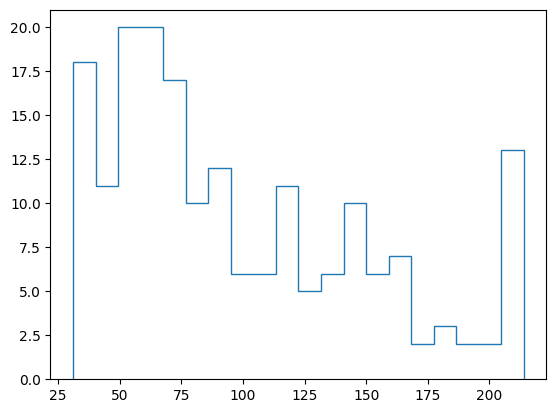

In [424]:
plt.stairs(a, b)

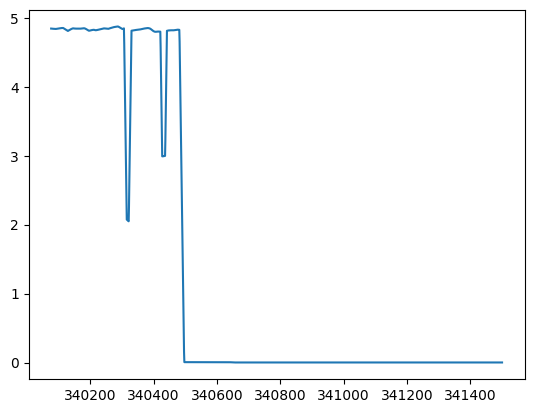

In [108]:
plt.plot(df[12][df[12]["Date"] == "2023-06-11"]["Level 2 Power [kW]"][:].rolling(1).mean())

In [443]:
monthly_events = {}
for site in df:
    
    filter_df = df[site][df[site]["Level 2 Power+ [kW]"] > 1.5]
    monthly_df = filter_df.groupby(["Month"])

    monthly_events[f"Site {site}"] = monthly_df["Level 2 Power+ [kW]"].mean()
    

In [444]:
monthly_events

{'Site 1': Month
 2022-08    7.693250
 2022-09    7.565819
 2022-10    7.328487
 2022-11    7.796973
 2022-12    7.298923
 Freq: M, Name: Level 2 Power+ [kW], dtype: float64,
 'Site 2': Month
 2022-08    3.651880
 2022-09    3.673806
 2022-10    3.766056
 2022-11    3.785186
 2022-12    3.752168
 2023-01    3.771056
 2023-02    3.765555
 2023-03    3.771055
 2023-04    3.767166
 2023-05    3.757342
 2023-06    3.766488
 2023-07    3.783464
 2023-08    3.763096
 2023-09    3.770892
 2023-10    3.791370
 Freq: M, Name: Level 2 Power+ [kW], dtype: float64,
 'Site 3': Month
 2022-08    5.018539
 2022-09    5.303947
 2022-10    5.628774
 2022-11    5.642320
 2022-12    5.606405
 2023-01    5.598689
 2023-02    5.584931
 2023-03    5.521578
 2023-04    5.603398
 2023-05    5.603487
 2023-06    5.586592
 2023-07    5.629524
 2023-09    5.590732
 Freq: M, Name: Level 2 Power+ [kW], dtype: float64,
 'Site 4': Month
 2022-08    6.217353
 2022-09    6.246242
 2022-10    5.886316
 2022-11    6.889

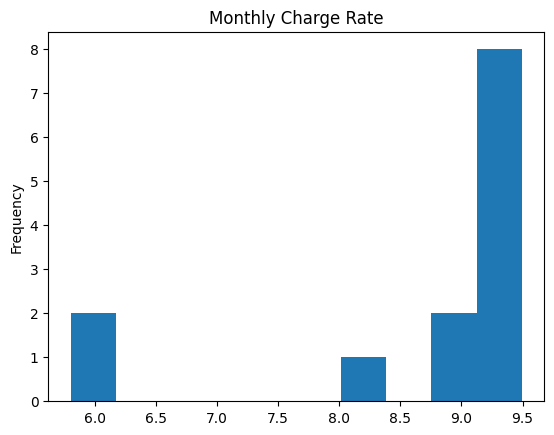

In [486]:
plot = monthly_events["Site 12"].plot(kind='hist', title="Monthly Charge Rate")

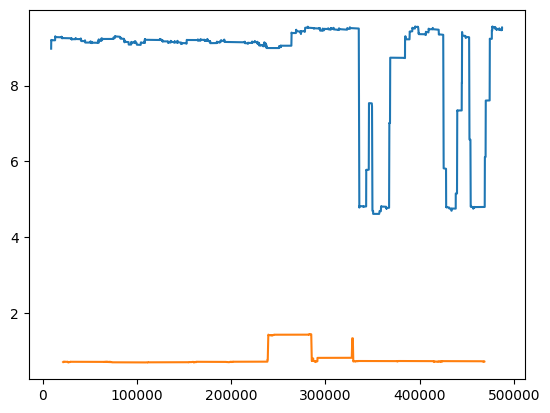

In [485]:
site = 12
filter1 = df[site][df[site]["Level 2 Power [kW]"]>1.5]
filter2 = df[site][df[site]["Level 1 Power [kW]"]>0.2]
# plt.plot(df[site]["Level 2 Power [kW]"].rolling(36000).mean()) # 25-day rolling average
# plt.plot(df[site]["Level 1 Power [kW]"].rolling(36000).mean()) # 25-day rolling average
plt.plot(filter1["Level 2 Power [kW]"].rolling(600).mean()) # 25-day rolling average
plt.plot(filter2["Level 1 Power [kW]"].rolling(600).mean()) # 25-day rolling average
plt.show()
# sns.boxplot(data=filter, x=filter["Month"], y="Level 2 Power [kW]")